This notebook will demonstrate how to use the **constrained training algorithms** implemented in this toolkit with **PyTorch**-like API.

The algorithms implemented in the **humancompatible.train.torch** subpackage share a similar idea. Before the training, you initialize an algorithm like you would a PyTorch one. Then, during the training process, you:

1. Evaluate a constraint and compute its gradient
2. Call the `dual_step` function to update dual parameters and save the constraint gradient for the primal update
3. Call the `step` function to update the primal parameters (generally, model weights)

Let's try the Stochastic Smooth Linearized Augmented Lagrangian (SSLALM) algorithm on a constrained learning task.

Let's train a simple classification model, putting a constraint on the norm of each layer's parameters.

In the canonical form, the algorithm expects equality constraints that are equal to 0; however, we can easily transform arbitrary inequality constraints to that form.

In [17]:
# load and prepare data

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import numpy as np
from folktables import ACSDataSource, ACSIncome, generate_categories

# load folktables data
data_source = ACSDataSource(survey_year="2018", horizon="1-Year", survey="person")
acs_data = data_source.get_data(states=["VA"], download=True)
definition_df = data_source.get_definitions(download=True)
categories = generate_categories(
    features=ACSIncome.features, definition_df=definition_df
)
df_feat, df_labels, _ = ACSIncome.df_to_pandas(
    acs_data, categories=categories, dummies=True
)

sens_cols = ["SEX_Female", "SEX_Male"]
features = df_feat.drop(columns=sens_cols).to_numpy(dtype="float")
groups = df_feat[sens_cols].to_numpy(dtype="float")
labels = df_labels.to_numpy(dtype="float")
# split
# indices - used later
indices = np.arange(len(features))
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    features, labels, groups, test_size=0.2, random_state=42
)
# scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# make into a pytorch dataset, remove the sensitive attribute
features_train = torch.tensor(X_train, dtype=torch.float32)
labels_train = torch.tensor(y_train, dtype=torch.float32)
sens_train = torch.tensor(groups_train)
dataset_train = torch.utils.data.TensorDataset(features_train, labels_train)

In [18]:
from humancompatible.train.optim import SSLALM
import torch
from torch.nn import Sequential

dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True)

hsize1 = 32
hsize2 = 32
model = Sequential(
    torch.nn.Linear(features_train.shape[1], hsize1),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize1, hsize2),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize2, 1),
)

m = len(list(model.parameters()))

optimizer = SSLALM(params=model.parameters(), m=m, lr=0.01, dual_lr=0.1)
# bounds for the constraints: norm of each param group should be <= 1
constraint_bounds = [1.0] * m

epochs = 10
criterion = torch.nn.BCEWithLogitsLoss()

In [19]:
for epoch in range(epochs):
    loss_log = []
    c_log = []
    slack_log = []
    duals_log = []
    for batch_input, batch_label in dataloader:
        # calculate constraints and constraint grads
        c_log.append([])
        for i, param in enumerate(model.parameters()):
            norm = torch.linalg.norm(param, ord=2)
            # convert constraint to equality
            norm_viol = torch.max(norm - constraint_bounds[i], torch.zeros(1))
            norm_viol.backward()
            # for the Lagrangian family of algorithms, dual_step requires the index of constraint and the value as arguments
            # to update the corresponding dual multiplier
            # in a stochastic-constrained setting, this estimate needs (in theory) to be independent from the one used to update dual parameters
            # in practice, it makes little difference
            optimizer.dual_step(i, c_val=norm_viol.squeeze())
            optimizer.zero_grad()
            c_log[-1].append(norm.detach().numpy())

        # calculate loss and grad
        batch_output = model(batch_input)
        loss = criterion(batch_output, batch_label)
        loss.backward()
        loss_log.append(loss.detach().numpy())
        duals_log.append(optimizer._dual_vars.detach())
        optimizer.step()
        optimizer.zero_grad()

    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
        f"dual: {np.mean(duals_log, axis=0)}"
    )

Epoch: 0, loss: 0.5530118942260742, constraints: [0.89227474 0.25078157 0.99991614 0.6301253  0.8879108  0.13028453], dual: [0.17121336 0.         0.28110412 0.         0.20761313 0.        ]
Epoch: 1, loss: 0.4475935399532318, constraints: [0.9997699  0.7850479  0.99946874 0.78288645 0.99974436 0.1714625 ], dual: [0.22368664 0.         0.33583456 0.         0.27761197 0.        ]
Epoch: 2, loss: 0.431843101978302, constraints: [0.9994712  0.99996763 0.9990707  0.8339326  0.99934065 0.18874547], dual: [0.26220715 0.04020481 0.3792869  0.         0.33054626 0.        ]
Epoch: 3, loss: 0.4251251518726349, constraints: [0.9992893  0.9998389  0.9988373  0.86017656 0.9990318  0.19272482], dual: [0.293601   0.04875389 0.41559145 0.         0.37250212 0.        ]
Epoch: 4, loss: 0.42006123065948486, constraints: [0.99927783 0.9997819  0.9986145  0.87985784 0.99881876 0.19854851], dual: [0.32055533 0.05508569 0.44721738 0.         0.40870485 0.        ]
Epoch: 5, loss: 0.41582372784614563, con

The model is now trained subject to the constraints we set.

---
---

It is also possible to train a network subject to **stochastic constraints**. One of the main use-cases for that is **fairness**. Let's train a network on the `folktables` dataset without constraints first, so we can identify some biases:

Define a model:

In [20]:
from torch.nn import Sequential

hsize1 = 64
hsize2 = 32
model_uncon = Sequential(
    torch.nn.Linear(features_train.shape[1], hsize1),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize1, hsize2),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize2, 1),
)

And start training:

In [21]:
from torch.optim import Adam

loader = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True)
loss = torch.nn.BCEWithLogitsLoss()
optimizer = Adam(model_uncon.parameters())
epochs = 50

for epoch in range(epochs):
    losses = []
    for batch_feat, batch_label in loader:
        optimizer.zero_grad()

        logit = model_uncon(batch_feat)
        loss = torch.nn.functional.binary_cross_entropy_with_logits(logit, batch_label)
        loss.backward()

        optimizer.step()
        losses.append(loss.item())
    print(f"Epoch: {epoch}, loss: {np.mean(losses)}")

Epoch: 0, loss: 0.4609499644861914
Epoch: 1, loss: 0.394243211997834
Epoch: 2, loss: 0.3818009611232058
Epoch: 3, loss: 0.37257700601663557
Epoch: 4, loss: 0.3629442303341565
Epoch: 5, loss: 0.3528368610205535
Epoch: 6, loss: 0.3421489662365105
Epoch: 7, loss: 0.3291203259493653
Epoch: 8, loss: 0.317415553651054
Epoch: 9, loss: 0.30314150411364943
Epoch: 10, loss: 0.29137436364967517
Epoch: 11, loss: 0.2774918695531502
Epoch: 12, loss: 0.2652607600891054
Epoch: 13, loss: 0.25187713304811693
Epoch: 14, loss: 0.2400089466757428
Epoch: 15, loss: 0.2305763658767753
Epoch: 16, loss: 0.21997606738834646
Epoch: 17, loss: 0.21113358203411928
Epoch: 18, loss: 0.20337038734689303
Epoch: 19, loss: 0.19535669643161205
Epoch: 20, loss: 0.1876445845749139
Epoch: 21, loss: 0.18207673622765755
Epoch: 22, loss: 0.17497290361505066
Epoch: 23, loss: 0.1692219314175081
Epoch: 24, loss: 0.16390423791218794
Epoch: 25, loss: 0.16064996867856352
Epoch: 26, loss: 0.1547056089274611
Epoch: 27, loss: 0.149944334

In [22]:
from fairret.statistic import PositiveRate, TruePositiveRate
from fairret.loss import NormLoss

preds = torch.nn.functional.sigmoid(model_uncon(features_train))
pr = PositiveRate()
pr(preds, sens_train)

tensor([0.3708, 0.5209], dtype=torch.float64, grad_fn=<IndexPutBackward0>)

---
---

Now let us train the same model with one of the **constrained** training algorithms:

Here, to make sure each batch contains representatives of each protected group, we can use the BalancedBatchSampler from the `utils` subpackage - a custom PyTorch `Sampler` which yields an equal number of samples from each subgroup in each batch.

In [23]:
from fairret.statistic import PositiveRate
from fairret.loss import NormLoss
from humancompatible.train.fairness.utils import BalancedBatchSampler

dataset = torch.utils.data.TensorDataset(features_train, sens_train, labels_train)

sampler = BalancedBatchSampler(
    group_onehot=sens_train, batch_size=128, drop_last=True
)
dataloader = torch.utils.data.DataLoader(dataset, batch_sampler=sampler)

criterion = torch.nn.BCEWithLogitsLoss()

statistic = PositiveRate()
fair_criterion = NormLoss(statistic=statistic)
fair_crit_bound = 0.2

In [24]:
from torch.nn import Sequential

hsize1 = 64
hsize2 = 32
model_con = Sequential(
    torch.nn.Linear(features_train.shape[1], hsize1),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize1, hsize2),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize2, 1),
)

from humancompatible.train.optim import SSLALM_Adam

optimizer = SSLALM_Adam(
    params=model_con.parameters(),
    m=1,
    lr=0.01,
    dual_lr=0.05,
    dual_bound=5,
    rho=1,
    mu=2,
)

# add slack variables
slack_vars = torch.zeros(1, requires_grad=True)
optimizer.add_param_group(param_group={"params": slack_vars, "name": "slack"})

epochs = 50

As the constraint, we use `NormLoss` from `fairret`, which penalizes the model based on the ratio between the value of a statistic for each group and the overall value: $\sum_{s\in S}{|1-\frac{f(\theta, X_s, y_s)}{f(\theta, X, y)}|}$, where $S$ is the set of groups.

In [25]:
import pandas as pd
import random

ep_c_log = []


for epoch in range(epochs):
    loss_log = []
    c_log = []
    duals_log = []

    for batch_input, batch_sens, batch_label in dataloader:
        # calculate constraints and constraint grads
        out = model_con(batch_input)
        fair_loss = fair_criterion(out, batch_sens)
        # fair_constraint = torch.max(fair_loss + slack_vars[0] - fair_crit_bound, torch.zeros(1))
        fair_constraint = fair_loss + slack_vars[0] - fair_crit_bound
        fair_constraint.backward(retain_graph=True)

        optimizer.dual_step(0, c_val=fair_constraint)
        optimizer.zero_grad()

        c_log.append([fair_loss.detach().item()])
        duals_log.append(optimizer._dual_vars.detach())
        # calculate loss and grad
        loss = criterion(out, batch_label) + 0 * slack_vars[0]
        loss.backward()
        loss_log.append(loss.detach().numpy())
        optimizer.step()
        optimizer.zero_grad()

        # slack variables must be non-negative. this is the "projection" step from the SSL-ALM paper
        with torch.no_grad():
            for s in slack_vars:
                if s < 0:
                    s.zero_()

    optimizer.dual_lr *= 0.95
    ep_c_log.extend(c_log)

    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
        f"dual: {np.mean(duals_log, axis=0)}"
    )

Epoch: 0, loss: 0.47561541199684143, constraints: [0.1455717], dual: [0.04459136]
Epoch: 1, loss: 0.4005184471607208, constraints: [0.19695416], dual: [0.05478862]
Epoch: 2, loss: 0.38591793179512024, constraints: [0.19802493], dual: [0.05006111]
Epoch: 3, loss: 0.3766694664955139, constraints: [0.19887625], dual: [0.03686672]
Epoch: 4, loss: 0.368755578994751, constraints: [0.19823972], dual: [0.01780558]
Epoch: 5, loss: 0.3644692301750183, constraints: [0.20568888], dual: [0.07910181]
Epoch: 6, loss: 0.3556845188140869, constraints: [0.199473], dual: [0.0779314]
Epoch: 7, loss: 0.3499906659126282, constraints: [0.20087822], dual: [0.08645613]
Epoch: 8, loss: 0.34126588702201843, constraints: [0.19704869], dual: [0.05937654]
Epoch: 9, loss: 0.33310431241989136, constraints: [0.19773883], dual: [0.03964673]
Epoch: 10, loss: 0.32456961274147034, constraints: [0.20578005], dual: [0.08775681]
Epoch: 11, loss: 0.31701552867889404, constraints: [0.20024664], dual: [0.0897069]
Epoch: 12, los

In [26]:
from fairret.statistic import PositiveRate

preds = torch.nn.functional.sigmoid(model_con(features_train))
pr = PositiveRate()
pr(preds, sens_train)

tensor([0.3871, 0.4702], dtype=torch.float64, grad_fn=<IndexPutBackward0>)

In [27]:
fair_criterion(model_con(features_train), sens_train)

tensor(0.1934, dtype=torch.float64, grad_fn=<SumBackward0>)

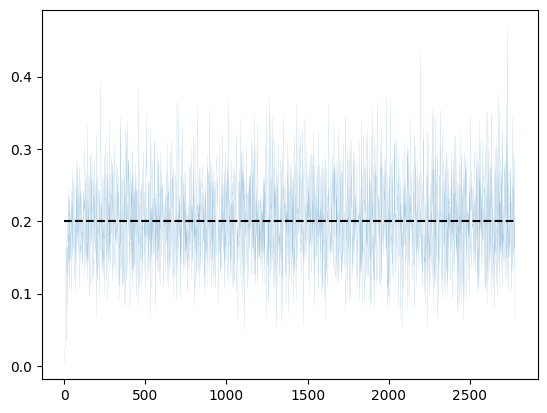

In [28]:
from matplotlib import pyplot as plt

window_len = 5
c_mavg = np.array(
    [np.mean(ep_c_log[i : i + window_len]) for i in range(0, len(ep_c_log), window_len)]
)
plt.plot(np.array(c_mavg).flatten(), lw=0.05)
plt.hlines(y=fair_crit_bound, xmin=0, xmax=len(c_mavg), colors="black", ls="--")

---

Now let's see how the **Switching Subgradient** algorithm deals with this task.

In [29]:
from fairret.statistic import PositiveRate
from fairret.loss import NormLoss
from humancompatible.train.fairness.utils import BalancedBatchSampler

dataset = torch.utils.data.TensorDataset(features_train, sens_train, labels_train)

sampler = BalancedBatchSampler(
    group_onehot=sens_train, batch_size=128, drop_last=True
)
dataloader = torch.utils.data.DataLoader(dataset, batch_sampler=sampler)

criterion = torch.nn.BCEWithLogitsLoss()

statistic = PositiveRate()
fair_criterion = NormLoss(statistic=statistic)
fair_crit_bound = 0.2

In [30]:
from humancompatible.train.optim import SSG

from torch.nn import Sequential

hsize1 = 64
hsize2 = 32
model_con = Sequential(
    torch.nn.Linear(features_train.shape[1], hsize1),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize1, hsize2),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize2, 1),
)

optimizer = SSG(params=model_con.parameters(), m=1, lr=0.05, dual_lr=0.05)

epochs = 150

In [31]:
ep_c_log = []
for epoch in range(epochs):
    loss_log = []
    c_log = []
    duals_log = []
    for batch_input, batch_sens, batch_label in dataloader:
        # calculate constraints and constraint grads
        out = model_con(batch_input)
        fair_loss = fair_criterion(out, batch_sens)
        fair_constraint = torch.max(fair_loss - fair_crit_bound, torch.zeros(1))
        fair_constraint.backward(retain_graph=True)

        optimizer.dual_step(0)
        optimizer.zero_grad()

        c_log.append([fair_loss.detach().item()])
        # calculate loss and grad
        # batch_output = model_con(batch_input)
        loss = criterion(out, batch_label)
        loss.backward()
        loss_log.append(loss.detach().numpy())
        optimizer.step(fair_constraint)
        optimizer.zero_grad()

    ep_c_log.append(c_log)

    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
    )

Epoch: 0, loss: 0.5807222723960876, constraints: [0.05399933], 
Epoch: 1, loss: 0.4384526312351227, constraints: [0.11207884], 
Epoch: 2, loss: 0.41882577538490295, constraints: [0.11960857], 
Epoch: 3, loss: 0.4122208058834076, constraints: [0.11336559], 
Epoch: 4, loss: 0.40625596046447754, constraints: [0.11699898], 
Epoch: 5, loss: 0.4009935259819031, constraints: [0.12060179], 
Epoch: 6, loss: 0.3984239399433136, constraints: [0.11422147], 
Epoch: 7, loss: 0.39631226658821106, constraints: [0.1176066], 
Epoch: 8, loss: 0.3904055058956146, constraints: [0.12327618], 
Epoch: 9, loss: 0.38895300030708313, constraints: [0.12228468], 
Epoch: 10, loss: 0.38483375310897827, constraints: [0.11787616], 
Epoch: 11, loss: 0.38596436381340027, constraints: [0.12269527], 
Epoch: 12, loss: 0.3844405710697174, constraints: [0.12013279], 
Epoch: 13, loss: 0.3767779767513275, constraints: [0.12161447], 
Epoch: 14, loss: 0.3768785893917084, constraints: [0.12118101], 
Epoch: 15, loss: 0.37373250722

In [32]:
from fairret.statistic import PositiveRate

preds = torch.nn.functional.sigmoid(model_con(features_train))
pr = PositiveRate()
pr(preds, sens_train)

tensor([0.4365, 0.4693], dtype=torch.float64, grad_fn=<IndexPutBackward0>)

In [33]:
fair_criterion(model_con(features_train), sens_train)

tensor(0.0722, dtype=torch.float64, grad_fn=<SumBackward0>)

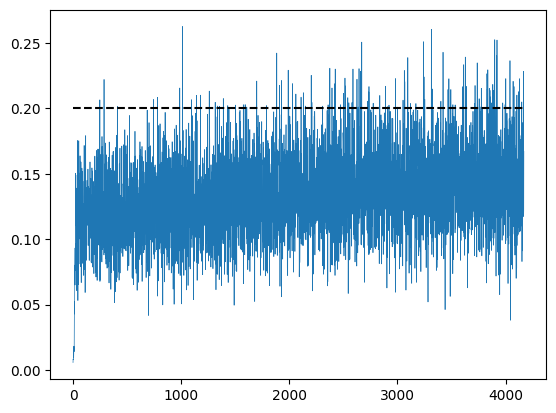

In [34]:
from matplotlib import pyplot as plt

ep_c_log = np.array(ep_c_log).flatten()
window_len = 10
c_mavg = np.array(
    [np.mean(ep_c_log[i : i + window_len]) for i in range(0, len(ep_c_log), window_len)]
)
plt.plot(np.array(c_mavg).flatten(), lw=0.5)
plt.hlines(y=fair_crit_bound, xmin=0, xmax=len(c_mavg), colors="black", ls="--")